# Lomb-Scargle Biases
## This can be used to reproduce Figure 1 from the paper

In [1]:
from mind_the_gaps.simulator import Simulator
from astropy.timeseries import LombScargle
from mind_the_gaps.utils.fitting import fit_psd_powerlaw, fit_lomb_scargle
import numpy as np
from astropy.modeling.powerlaws import PowerLaw1D
import random
from multiprocessing import Pool
import matplotlib.pyplot as plt
import os
np.random.seed(27)

Below set input beta to 1 or 1.8

In [2]:
betas = [1, 1.8]
mean = 3
dt = 1

input_beta = betas[1] # set to betas[1] for the other index

outdir = "beta_%.1f" % input_beta
if not os.path.isdir(outdir):
    os.mkdir(outdir)
# 1,000 datapoint lightcurve
timestamps = np.arange(0, 1000, dt)
# amplitude here sets the variance, which does not play a big role
psd_model = PowerLaw1D(amplitude=1, alpha=input_beta)

simulator = Simulator(psd_model, timestamps, np.ones(len(timestamps)) * dt, mean, aliasing_factor=1,
                     extension_factor=1.5) # very important to set it to 1

## Let's generate a lightcurve to ensure things are working as expected

/home/andresgur/anaconda3/lib/python3.9/site-packages/stingray/utils.py:403: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment. All analysis in the light curve will assume Poisson errors. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


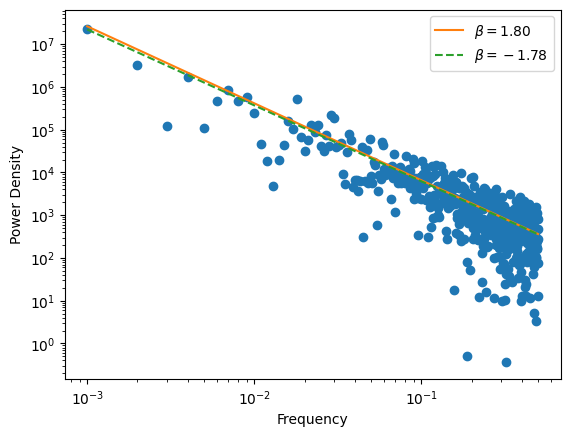

In [3]:
lc_rates = simulator.generate_lightcurve() # 
# PSD
freqs = np.fft.rfftfreq(len(timestamps), dt)
# For even fourier transforms we need to ignore the nyquist frequency (Vaughan +2005)
if len(freqs) % 2 == 0:
    pow_spec = (np.absolute(np.fft.rfft(lc_rates)[1:-1])) ** 2
    frequencies = freqs[1:-1]
else:
    pow_spec = (np.absolute(np.fft.rfft(lc_rates)[1:])) ** 2
    frequencies = freqs[1:]

plt.figure()
plt.xscale("log")
plt.yscale("log")
plt.scatter(frequencies, pow_spec)
psd_slope, err, psd_norm, psd_norm_err = fit_psd_powerlaw(frequencies, pow_spec)
plt.plot(frequencies, psd_norm * frequencies ** -input_beta, color="C1", label="$\\beta = %.2f$" % input_beta)
plt.plot(frequencies, psd_norm * frequencies ** psd_slope, color="C2", label="$\\beta = %.2f$" % psd_slope,
         ls="--")
plt.legend()
plt.xlabel("Frequency")
plt.ylabel("Power Density")
plt.savefig("%s/psd.png" % outdir, bbox_inches='tight')

## Generate N lightcurves

In [4]:
def simulate_lc(n):
    return simulator.generate_lightcurve()

In [5]:
simulator = Simulator(psd_model, timestamps, np.ones(len(timestamps)) * dt, mean, aliasing_factor=1,
                     extension_factor=10, random_state=27) # now 10 times longer
cores = 15
N_sims = 1000
with Pool(processes=cores, initializer=np.random.seed) as pool:
    rates = pool.map(simulate_lc, range(N_sims))

/home/andresgur/anaconda3/lib/python3.9/site-packages/stingray/utils.py:403: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment. All analysis in the light curve will assume Poisson errors. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/andresgur/anaconda3/lib/python3.9/site-packages/stingray/utils.py:403: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment. All analysis in the light curve will assume Poisson errors. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/andresgur/anaconda3/lib/python3.9/site-packages/stingray/utils.py:403: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment. All analysis in the light curve will assume Poisson errors. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/andresgur/anaconda3/lib/python3.9/site-packages/stingray/utils.py:403: UserWarning: S

## Check indices of the simulated lightcurves to ensure everything is ok

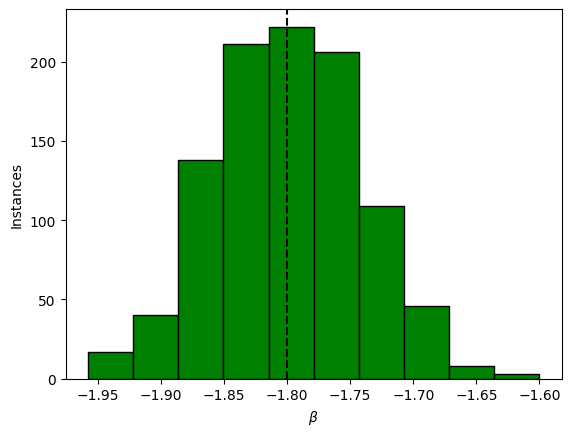

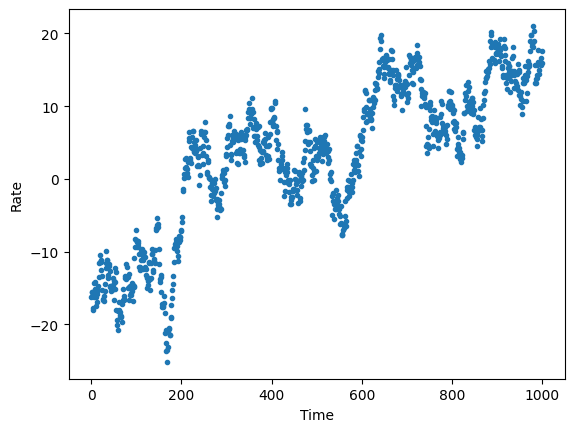

In [6]:
slopes = np.ones(N_sims)
for index, rate in enumerate(rates):
    # For even fourier transforms we need to ignore the nyquist frequency (Vaughan +2005)
    if len(freqs) % 2 == 0:
        pow_spec = (np.absolute(np.fft.rfft(rate)[1:-1])) ** 2
        frequencies = freqs[1:-1]
    else:
        pow_spec = (np.absolute(np.fft.rfft(rate)[1:])) ** 2
        frequencies = freqs[1:]
    psd_slope, err, psd_norm, psd_norm_err = fit_psd_powerlaw(frequencies, pow_spec)
    slopes[index] = psd_slope

plt.figure()
plt.hist(slopes, bins=10, facecolor="green", edgecolor="black")
plt.axvline(-input_beta, ls="--", color="black")
plt.xlabel("$\\beta$")
plt.ylabel("Instances")
np.mean(slopes)
np.std(slopes)
plt.savefig("%s/histo_beta.png" % outdir, facecolor="white", bbox_inches='tight')
# plot a template lightcurve
plt.figure()
plt.scatter(timestamps, rates[0], marker=".")
plt.xlabel("Time")
plt.ylabel("Rate")
plt.savefig("%s/template_lc.png" % outdir, bbox_inches='tight')

## Define frequency range

In [7]:
fmax = 1 / (2 * dt) # Nyquist
fmin = 1 / (timestamps[-1] - timestamps[0])
samples_per_peak = 1
ls_norm = "psd" # not so important
# remove Nyquist frequency as it follows Chi^2_1 not Chi^2_2
frequencies = np.linspace(fmin, fmax, len(rate) // 2)[:-1]

## Remove samples and retrieve the index

In [8]:
# up to 501 so remove max 500 samples in batches of 50
rem_samples = np.arange(0, 501, 50, dtype=int)
# Fitting
ls_slopes = np.ones((len(rem_samples), N_sims))
# loop samples to remove
for rem_index, rem in enumerate(rem_samples):
    # fix indices used to remove datapoints, keeping first and last datapoints
    del_indexes = random.sample(range(1, len(timestamps)), rem)
    # timestamps are the same for all lcs
    uneven_timestamps = np.delete(timestamps, del_indexes)
    # loop all lightcurves
    for index, rate in enumerate(rates):
        uneven_rate = np.delete(rate, del_indexes)
        ls = LombScargle(uneven_timestamps, uneven_rate, fit_mean=True, nterms=1, center_data=True,
                         normalization=ls_norm)
        power = ls.power(frequencies, method="fast")
        # Fitting
        psd_slope, err, norm, norm_err = fit_lomb_scargle(frequencies, power)
        ls_slopes[rem_index, index] = psd_slope

## Plot the results

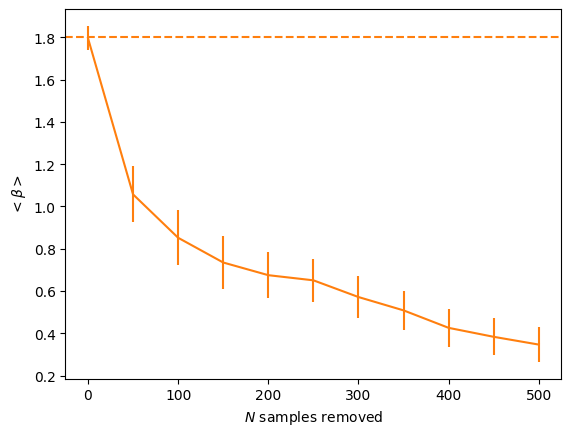

In [9]:
plt.figure()
plt.errorbar(rem_samples, -np.mean(ls_slopes, axis=1), yerr=np.std(ls_slopes, axis=1), 
             color="C1")
plt.axhline(input_beta, ls="--", color="C1")
plt.xlabel("$N$ samples removed")
plt.ylabel("$<\\beta>$")
plt.savefig("%s/samples_removed.png" % (outdir), bbox_inches="tight")
outputs = np.asarray([rem_samples, np.mean(ls_slopes, axis=1), np.std(ls_slopes, axis=1)])
np.savetxt("%s/best_fit_beta.dat" % (outdir), outputs.T, delimiter="\t", fmt="%.2f", header="samples\tbeta\tstd")